In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from pathlib import Path

import numpy as np
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

from dataclasses import dataclass, field
import pandas as pd


Setting up real-world dataset

In [2]:
real_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

real_dataset_path = 'real_datasets/'
train_dataset_path = 'data/dataset-resized/'

train_dataset = ImageFolder(train_dataset_path, transform = data_transform)
len_labels = len(train_dataset.classes)
print(len_labels)

6


In [3]:
idx2label_dict = {idx: classes for idx, classes in enumerate(train_dataset.classes)}
label2idx_dict = {classes: idx for idx, classes in enumerate(train_dataset.classes)}
idx2label_dict

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [11]:
label2idx_dict

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [13]:
class RecursiveImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = list(Path(root).rglob("*.jpg")) + list(Path(root).rglob("*.jpeg"))
        if len(self.paths) == 0:
            raise ValueError(f"No .jpg files found in {root}! Check path and structure.")
        self.transform = transform
        print(f"Found {len(self.paths)} images")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(str(self.paths[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
            
        # Label = parent folder name (cardboard, plastic, etc.)
        label = self.paths[idx].parent.name
        return img, label2idx_dict[label]

# Usage
real_dataset = RecursiveImageDataset("real_datasets", transform = real_transform)
print(f"Loaded {len(real_dataset)} real images")

Found 104 images
Loaded 104 real images


In [14]:
real_dataset.paths

[PosixPath('real_datasets/paper/webcam_snapshot_5c925a0d-9c60-435b-bf8e-1749a6b917e5.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_03a1a97e-08f5-491a-8f98-b6c87f651786.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_34180090-fcd3-4f3b-8611-7aa0aadf1472.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_526a9903-1474-428e-a9d8-6b9fced6fe8d.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_0fe1efa2-b8cd-435a-948e-01d604e6a4ae.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_124a21aa-a7d4-4d9d-b42a-b9fdbdf6598d.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_e9e20640-41dc-4272-a83b-2ddf1d062237.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_c09d3893-bbc3-46d3-a734-bf567c00286d.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_6df58739-cd5d-469e-a695-2ab4069e8a7d.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_3337b4da-57c4-4eed-8a85-d652a14c85b5.jpg'),
 PosixPath('real_datasets/paper/webcam_snapshot_298356f0-bade-45e3-b69f-a3a47c75

In [15]:
img, label = real_dataset[0]
label

3

In [16]:
batch_size = 8
dataset_loader = DataLoader(
    train_dataset,
    batch_size,
    shuffle = True,
    num_workers = 4,
    pin_memory = False
)

real_loader = DataLoader(
    real_dataset,
    batch_size,
    shuffle = True,
    num_workers = 4,
    pin_memory = False
)

### Load the weights

In [17]:
import torchvision.models as models
import os

checkpoint_path = "checkpoints/"
device = "cuda:0"
# Load the MobileNetV3_Small model
model = models.mobilenet_v3_small(pretrained=False)

# Modify the classifier to match the number of our output classes
num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 1024),
    nn.Hardswish(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Identity()  # <--- we stop here
)

best_model_path = os.path.join(checkpoint_path, 'best_model.pth')
# Load best model for prediction
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path), strict = False)
    print("Loaded best model for prediction")

model = model.to(device)
model.eval()
print("MobileNetV3_Small model loaded and classifier modified.")


Loaded best model for prediction
MobileNetV3_Small model loaded and classifier modified.


In [18]:
# Use only the backbone
feature_extractor = model.features
avgpool = nn.AdaptiveAvgPool2d(1)

feature_extractor = feature_extractor.to(device)
avgpool = avgpool.to(device)

In [19]:
def extract_features(loader, name):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc = f"Extracting {name}"):
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            feats = avgpool(feats).flatten(1)
            features.append(feats.cpu().numpy())
            labels.append([name] * len(imgs))

    return np.concatenate(features), labels

print("Extracting TrashNet features...")
feat_t, label_t = extract_features(dataset_loader, "TrashNet")

print("Extracting Real-world features...")
feat_r, label_r = extract_features(real_loader, "Real-world")

Extracting TrashNet features...


Extracting TrashNet:   0%|          | 0/318 [00:00<?, ?it/s]

Extracting Real-world features...


Extracting Real-world:   0%|          | 0/13 [00:00<?, ?it/s]

In [20]:
# Combine
from itertools import chain

X = np.vstack([feat_t, feat_r])
y = label_t + label_r
y = list(chain.from_iterable(y))


print("Running t-SNE...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42,
    metric="cosine",  # better for high-dim embeddings
    init="pca"
)
X_2d = tsne.fit_transform(X)


Running t-SNE...


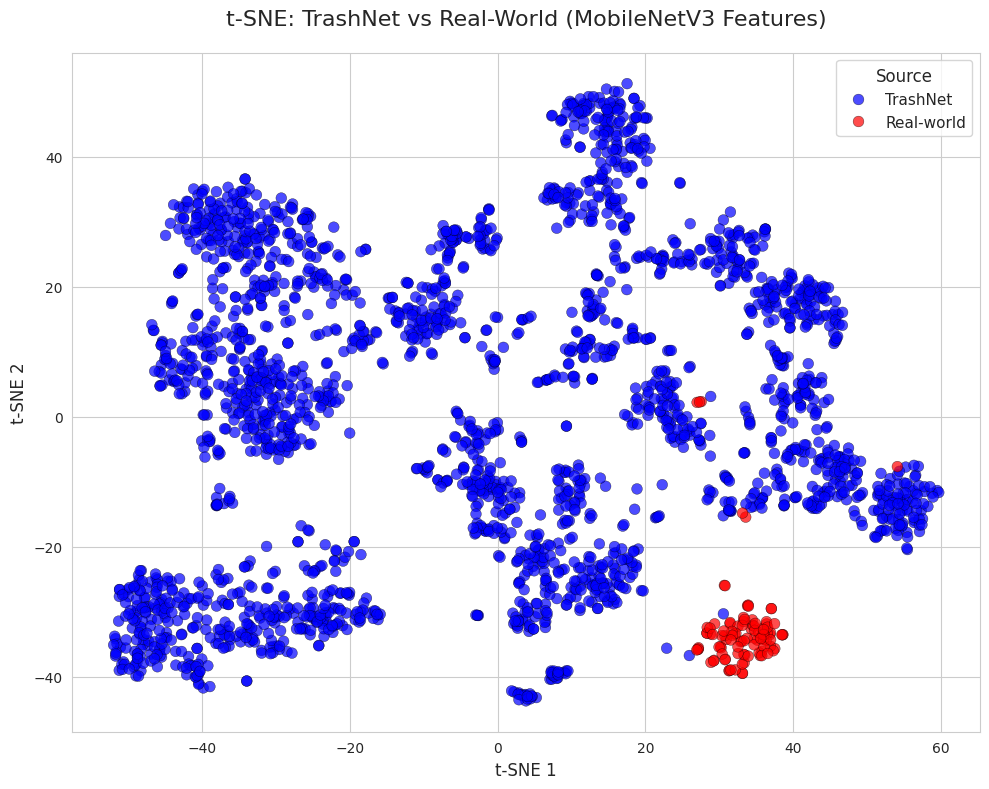

Done! Image saved as 'shift_tsne_seaborn.png'


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "t-SNE 1": X_2d[:, 0],
    "t-SNE 2": X_2d[:, 1],
    "Dataset": y
})

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Define colors
palette = {
    "TrashNet": "blue",
    "Real-world": "red"
    # If your dataset uses different names, update above
}

# Plot with seaborn
sns.scatterplot(
    data=df,
    x="t-SNE 1",
    y="t-SNE 2",
    hue="Dataset",
    palette=palette,
    alpha=0.7,
    s=60,  # marker size
    edgecolor="k",
    linewidth=0.3
)

# Customize
plt.title("t-SNE: TrashNet vs Real-World (MobileNetV3 Features)", fontsize=16, pad=20)
plt.xlabel("t-SNE 1", fontsize=12)
plt.ylabel("t-SNE 2", fontsize=12)
plt.legend(title="Source", title_fontsize=12, fontsize=11, loc="best")

# Tight layout
plt.tight_layout()

# Save
plt.savefig("shift_tsne_seaborn.png", dpi=300, bbox_inches='tight')
plt.show()

print("Done! Image saved as 'shift_tsne_seaborn.png'")

In [22]:
def extract_features_classes(loader, name):
    features = []
    sources = []
    classes = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc = f"Extracting {name}"):
            imgs = imgs.to(device)
            # print(labels)
            feats = feature_extractor(imgs)
            feats = avgpool(feats).flatten(1)
            features.append(feats.cpu().numpy())
            sources.append([name] * len(imgs))
            classes.append(labels.cpu().numpy())

    return np.concatenate(features), sources, classes

print("Extracting TrashNet features...")
feat_t, source_t, label_t = extract_features_classes(dataset_loader, "TrashNet")

print("Extracting Real-world features...")
feat_r, source_r, label_r = extract_features_classes(real_loader, "Real-world")

Extracting TrashNet features...


Extracting TrashNet:   0%|          | 0/318 [00:00<?, ?it/s]

Extracting Real-world features...


Extracting Real-world:   0%|          | 0/13 [00:00<?, ?it/s]

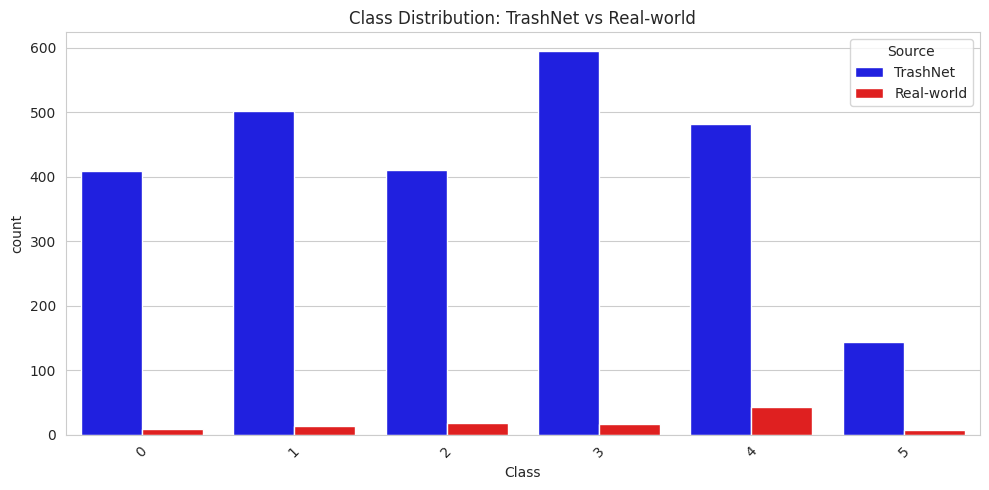

In [25]:
# Stack everything
X = np.vstack([feat_t, feat_r])
sources = source_t + source_r
sources = list(chain.from_iterable(sources))
classes = label_t + label_r
classes = list(chain.from_iterable(classes))

# --------------------------------------------------
# 1. Class distribution comparison
# --------------------------------------------------
df_dist = pd.DataFrame({
    "Source": sources,
    "Class" : classes
})

plt.figure(figsize=(10, 5))
sns.countplot(data=df_dist, x="Class", hue="Source", palette=["blue", "red"])
plt.title("Class Distribution: TrashNet vs Real-world")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Saved: tsne_compare_dataset.png


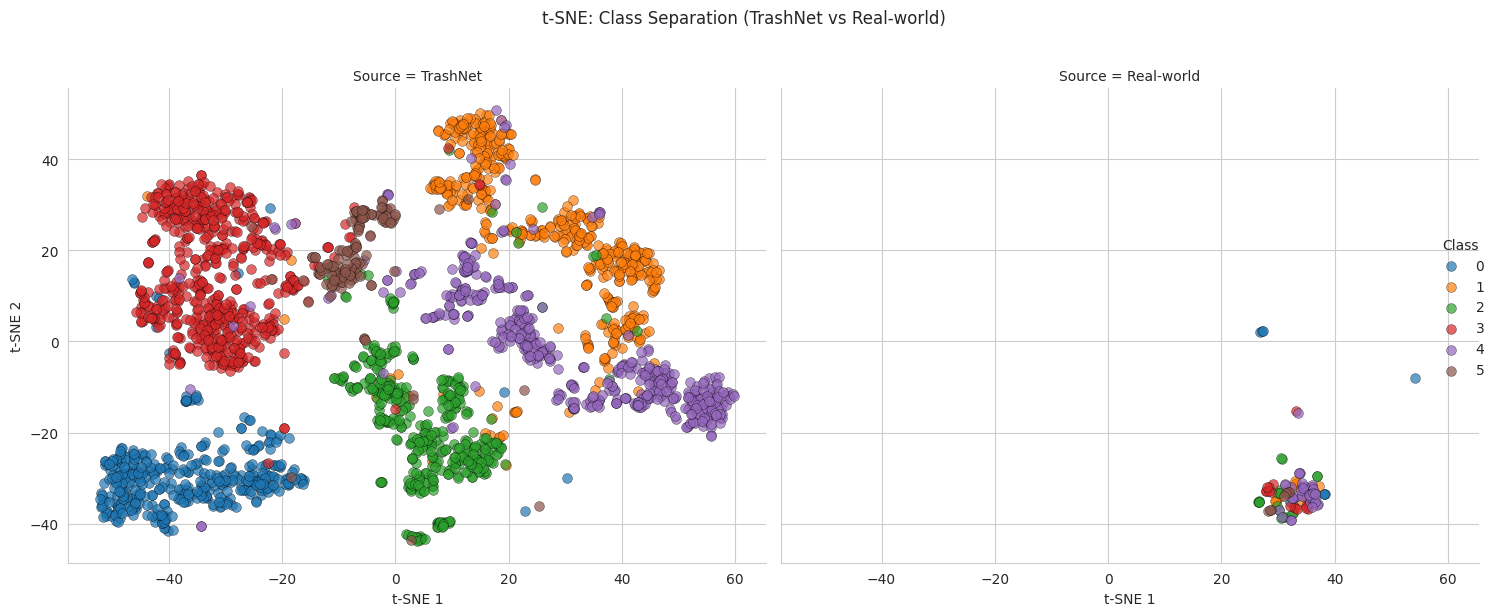

In [36]:
# Run t-SNE (same as before)
X_2d = TSNE(n_components=2, perplexity=30, metric="cosine",
            init="pca", random_state=42, max_iter=1000).fit_transform(X)

df_plot = pd.DataFrame({
    "t-SNE 1": X_2d[:, 0],
    "t-SNE 2": X_2d[:, 1],
    "Source" : sources,
    "Class"  : classes
})

# Plot: one subplot per source
g = sns.FacetGrid(df_plot, col="Source", hue="Class", height=6, aspect=1.2,
                  palette="tab10")
g.map_dataframe(sns.scatterplot, "t-SNE 1", "t-SNE 2", alpha=0.7, s=50, edgecolor="k", linewidth=0.3)
g.add_legend(title="Class")
g.fig.suptitle("t-SNE: Class Separation (TrashNet vs Real-world)", y=1.02)
plt.tight_layout()
plt.savefig("tsne_compare_dataset.png", dpi=300, bbox_inches='tight')
print("Saved: tsne_compare_dataset.png")

plt.show()

Found 6 classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Saved: tsne_per_class_grid.png


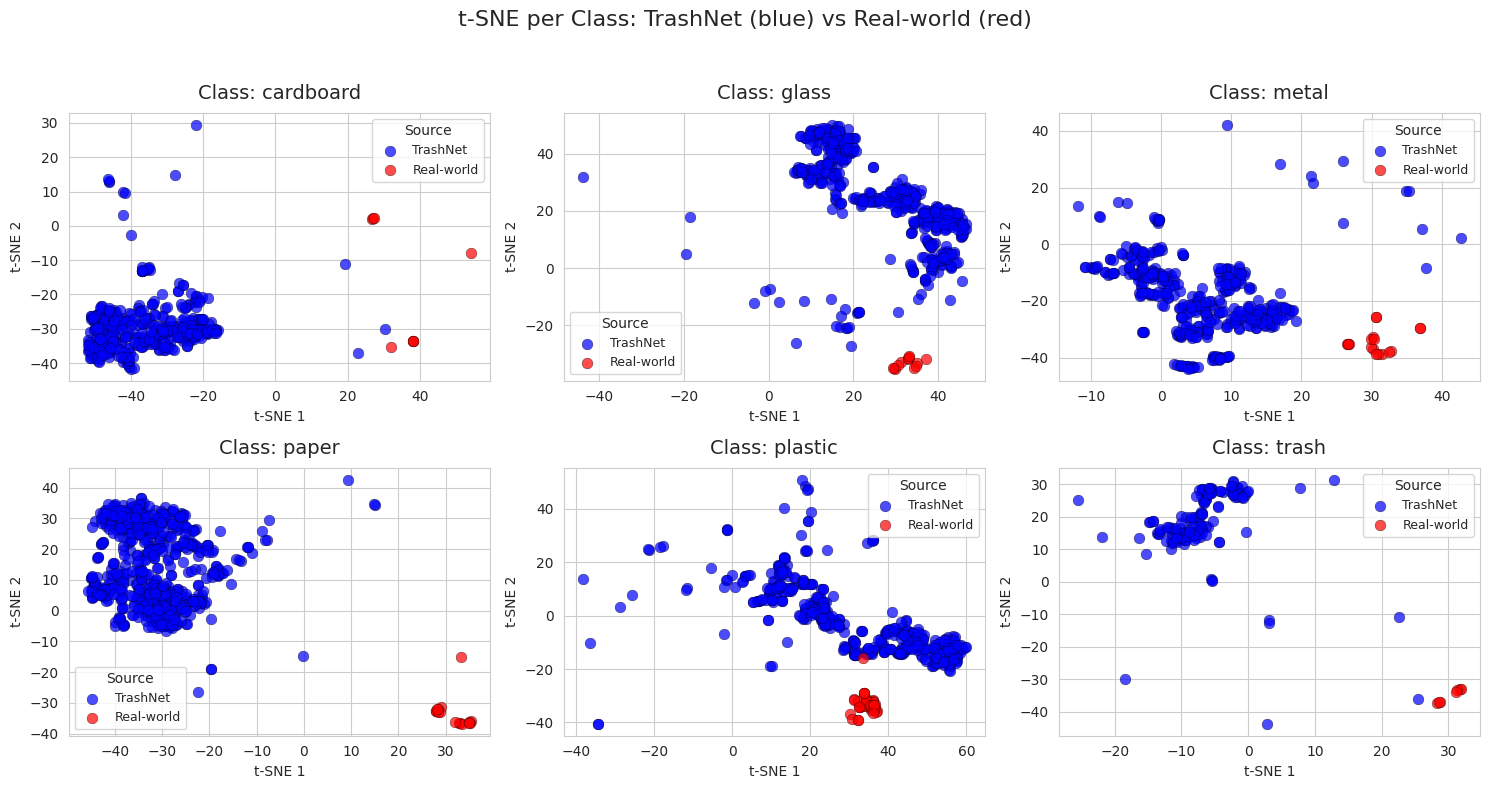

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --------------------------------------------------
# 2. Get unique classes (sorted)
# --------------------------------------------------
unique_classes = sorted(df_plot["Class"].unique())
n_classes = len(unique_classes)
print(f"Found {n_classes} classes: {unique_classes}")

# --------------------------------------------------
# 3. Create one plot per class
# --------------------------------------------------
cols = 3  # change to 2 or 4 if you have few/many classes
rows = (n_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() if n_classes > 1 else [axes]

sns.set_style("whitegrid")

for idx, cls in enumerate(unique_classes):
    ax = axes[idx]
    subset = df_plot[df_plot["Class"] == cls]

    # Plot TrashNet and Real-world
    sns.scatterplot(
        data=subset[subset["Source"] == "TrashNet"],
        x="t-SNE 1", y="t-SNE 2",
        color="blue", label="TrashNet", alpha=0.7, s=60,
        ax=ax, edgecolor="k", linewidth=0.3
    )
    sns.scatterplot(
        data=subset[subset["Source"] == "Real-world"],
        x="t-SNE 1", y="t-SNE 2",
        color="red", label="Real-world", alpha=0.7, s=60,
        ax=ax, edgecolor="k", linewidth=0.3
    )

    ax.set_title(f"Class: {idx2label_dict[cls]}", fontsize=14, pad=10)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend(title="Source", fontsize=9, title_fontsize=10)

# Remove empty subplots
for idx in range(n_classes, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle("t-SNE per Class: TrashNet (blue) vs Real-world (red)", 
             fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# --------------------------------------------------
# 4. Save high-res
# --------------------------------------------------
plt.savefig("tsne_per_class_grid.png", dpi=300, bbox_inches='tight')
print("Saved: tsne_per_class_grid.png")
plt.show()
